# Import Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, WeightedRandomSampler
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


import time

from collections import Counter

np.random.seed(42)

# Task 1: Frequency-based baseline

In [ ]:
# Read datasets
df = pd.read_json('/content/train.json')
df_test = pd.read_json('/content/test.json')

display(df.info())

api_calls = df['api_call_sequence']
vocabulary = set().union(*api_calls)
vocabulary.add('UNK')
print("training vocabulary size:", len(vocabulary))

api_calls_test = df_test['api_call_sequence']
test_voc = set().union(*api_calls_test)
print("test vocabulary size:", len(test_voc))

print("Total length:", len(vocabulary.union(test_voc))) #There are some strings that are not in the training vocabulary

df_freq_train = pd.DataFrame(
    [Counter(vec) for vec in df['api_call_sequence']],
    index=df.index
).reindex(columns=vocabulary, fill_value=0).fillna(0).astype(int)

display(df_freq_train.head())

unkowns = test_voc.difference(vocabulary)
print("NOT IN TRAINING SET:",unkowns)
df_test.replace(unkowns, 'UNK', inplace=True) # Replace unknown words in the test set with UNK

df_freq_test = pd.DataFrame(
    [Counter(vec) for vec in df_test['api_call_sequence']],
    index=df_test.index
).reindex(columns=vocabulary, fill_value=0).fillna(0).astype(int)

display(df_freq_test.head())

avg_train = (df_freq_train != 0).sum(axis=1).mean()
print("Average number of non-zero values in training data:", avg_train)

avg_test = (df_freq_test != 0).sum(axis=1).mean()
print("Average number of non-zero values in test data:", avg_test)

ratio = (df_freq_train != 0).sum(axis=1) / df_freq_train.shape[1]
avg_ratio_train = ratio.mean()
print("Average ratio of non-zero values per row in training data:", avg_ratio_train)

ratio = (df_freq_test != 0).sum(axis=1) / df_freq_test.shape[1]
avg_ratio_test = ratio.mean()
print("Average ratio of non-zero values per row in test data:", avg_ratio_test)

X_train = df_freq_train.values
y_train = df['is_malware'].values

X_test = df_freq_test.values
y_test = df_test['is_malware'].values

bal_train = y_train.sum()/len(y_train)
print("Percentage of malware in training data:", round(bal_train*100,10))

bal_test = y_test.sum()/len(y_test)
print("Percentage of malware in testing data:", round(bal_test*100,10))

#Create validation set by splitting the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Standardization of features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16325 entries, 0 to 16324
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   api_call_sequence  16325 non-null  object
 1   is_malware         16325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 255.2+ KB


None

training vocabulary size: 259
test vocabulary size: 232
Total length: 262


,CryptAcquireContextW,NtEnumerateKey,InternetCrackUrlA,LdrLoadDll,SetFilePointer,CopyFileExW,RegEnumKeyExA,NtCreateThreadEx,CopyFileW,RemoveDirectoryA,...,ioctlsocket,GetDiskFreeSpaceExW,listen,StartServiceA,CertOpenSystemStoreW,NtReadVirtualMemory,LoadResource,OpenServiceA,IsDebuggerPresent,connect
0,0,0,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,0
1,0,2,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,21,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,0,0
4,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,16,0,0,0


NOT IN TRAINING SET: {'ControlService', 'WSASocketA', 'NtDeleteKey'}


,CryptAcquireContextW,NtEnumerateKey,InternetCrackUrlA,LdrLoadDll,SetFilePointer,CopyFileExW,RegEnumKeyExA,NtCreateThreadEx,CopyFileW,RemoveDirectoryA,...,ioctlsocket,GetDiskFreeSpaceExW,listen,StartServiceA,CertOpenSystemStoreW,NtReadVirtualMemory,LoadResource,OpenServiceA,IsDebuggerPresent,connect
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,23,0,0,0
1,0,0,0,5,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,0
3,1,0,0,9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Average number of non-zero values in training data: 21.94707503828484
Average number of non-zero values in test data: 24.278247501921598
Average ratio of non-zero values per row in training data: 0.08473774146055922
Average ratio of non-zero values per row in test data: 0.09373840734332664
Percentage of malware in training data: 96.2572741194
Percentage of malware in testing data: 96.2644119908


In [ ]:
api_vocab = sorted(vocabulary)
api_vocab = ["PAD"] + api_vocab # Add PAD to pad sequences, assign it id = 0
api_to_idx = {api: idx for idx, api in enumerate(api_vocab)}
idx_to_api = {idx: api for api, idx in api_to_idx.items()}
print(api_to_idx)
print(idx_to_api)
print(api_to_idx['UNK'])
print(len(api_to_idx))

{'PAD': 0, 'CertOpenStore': 1, 'CertOpenSystemStoreW': 2, 'CoCreateInstance': 3, 'CoCreateInstanceEx': 4, 'CoGetClassObject': 5, 'CoInitializeEx': 6, 'CoInitializeSecurity': 7, 'CoUninitialize': 8, 'CopyFileA': 9, 'CopyFileExW': 10, 'CopyFileW': 11, 'CreateActCtxW': 12, 'CreateDirectoryW': 13, 'CreateJobObjectW': 14, 'CreateProcessInternalW': 15, 'CreateRemoteThread': 16, 'CreateServiceA': 17, 'CreateServiceW': 18, 'CreateThread': 19, 'CreateToolhelp32Snapshot': 20, 'CryptAcquireContextA': 21, 'CryptAcquireContextW': 22, 'CryptCreateHash': 23, 'CryptDecodeObjectEx': 24, 'CryptDecrypt': 25, 'CryptEncrypt': 26, 'CryptExportKey': 27, 'CryptGenKey': 28, 'CryptHashData': 29, 'CryptProtectData': 30, 'CryptProtectMemory': 31, 'DeleteFileW': 32, 'DeleteUrlCacheEntryA': 33, 'DeleteUrlCacheEntryW': 34, 'DeviceIoControl': 35, 'DnsQuery_A': 36, 'DrawTextExA': 37, 'DrawTextExW': 38, 'EnumServicesStatusA': 39, 'EnumWindows': 40, 'FindFirstFileExA': 41, 'FindFirstFileExW': 42, 'FindResourceA': 43, 'F

### Shallow NN Classifier

 - 64 neurons
 - cross entropy
 - adam optimizer
 - batch size : 64

In [ ]:

#Shallow NN classifier: using 64 neurons, Cross Entropy as loss function, ADAM as optimizer
neurons = 64
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class ShallowNN(nn.Module):
  def __init__(self, input_size, hidden_units):
        super(ShallowNN, self).__init__()
        self.hidden_layer = nn.Linear(in_features=input_size, out_features=hidden_units)
        self.output_layer = nn.Linear(in_features=hidden_units,out_features=2)
        self.relu = nn.ReLU()

  def forward(self, x):
      x = self.hidden_layer(x)
      x = self.relu(x)
      return self.output_layer(x)

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta = None, patience = None):
    start_time = time.time()
    num_epochs = 100
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    trigger_times = 0     # how many epochs since last improvement
    best_model_state = None
    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # ---- Early Stopping ----
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

    # ---- Restore best model ----
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def testing_model(model, dataloader, device):
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy


def evaluate_model(model, dataloader, device, dataset_name=""):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    report = classification_report(all_labels, all_predictions, output_dict=True)

    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(all_labels, all_predictions))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, report, all_predictions, all_probabilities


The device is set to: cuda
Epoch 20/100, Train Loss: 0.1930, Val Loss: 0.2350
Epoch 40/100, Train Loss: 0.1066, Val Loss: 0.1686
Early stopping at epoch 41 (best val loss: 0.164574)
The function took 16.6279 seconds to execute.


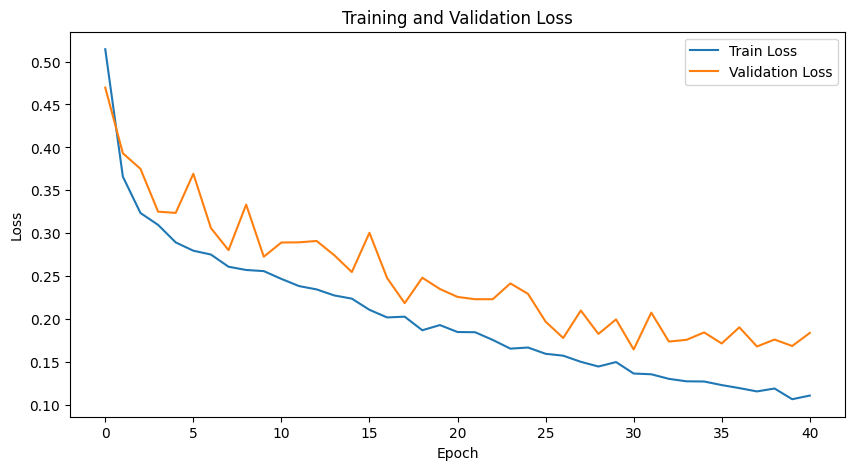


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.88      0.50       104
           1       1.00      0.95      0.97      3161

    accuracy                           0.94      3265
   macro avg       0.67      0.92      0.74      3265
weighted avg       0.98      0.94      0.96      3265



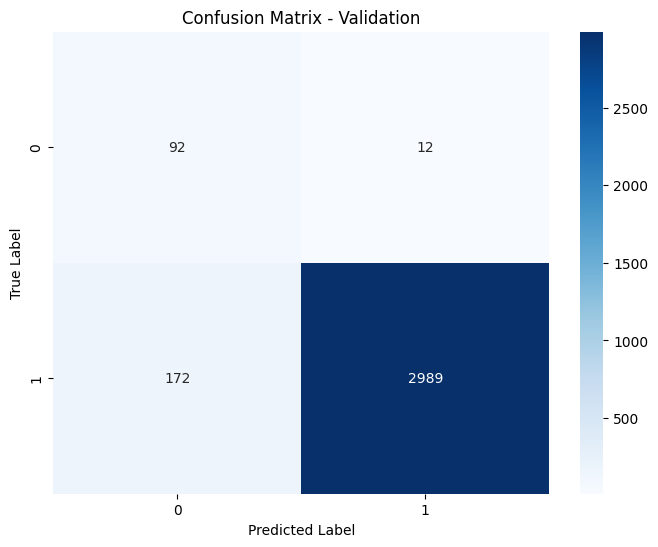


Test Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.53       243
           1       0.99      0.96      0.97      6262

    accuracy                           0.95      6505
   macro avg       0.70      0.86      0.75      6505
weighted avg       0.97      0.95      0.96      6505



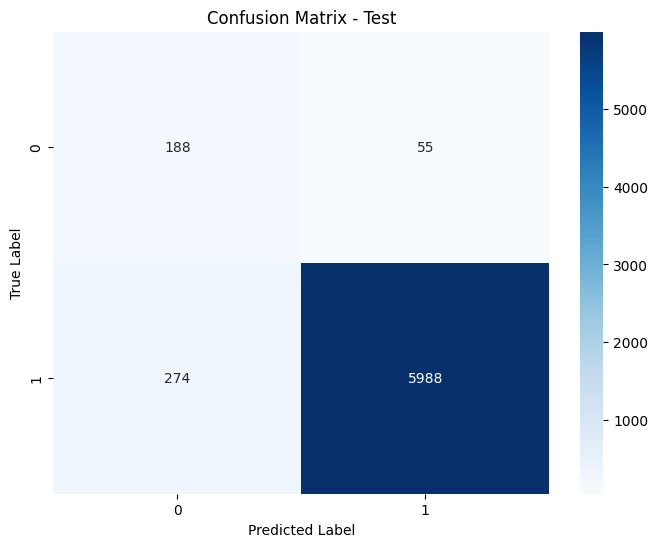

The function took 0.1682 seconds to execute.
The function took 0.0404 seconds to execute.
The function took 0.0864 seconds to execute.
Train Accuracy: 95.0000
Validation Accuracy: 94.3645
Test Accuracy: 94.9424


In [ ]:
#Create Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Weights to let the model better learn minority class
class_counts = torch.bincount(y_train_tensor)
sample_weights = 1.0 / class_counts[y_train_tensor]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")
model = ShallowNN(259,neurons) # 259 <-- number of columns in the dataset
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta=0.001, patience=10)

#report on classification report per model
val_accuracy, val_report, _, _ = evaluate_model(model, val_loader, device, "Validation")
test_accuracy, test_report, _, _ = evaluate_model(model, test_loader, device, "Test")

#testing
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Task 2: Feed Forward Neural Network (FFNN)

In [ ]:
# Analyze sequences length

sequence_lengths_train = df['api_call_sequence'].apply(len)
sequence_lengths_test = df_test['api_call_sequence'].apply(len)

print(f"Training set - Sequence length stats:")
print(f"Min: {sequence_lengths_train.min()}, Max: {sequence_lengths_train.max()}")
print(f"Mean: {sequence_lengths_train.mean():.2f}, Std: {sequence_lengths_train.std():.2f}")
print(f"Median: {sequence_lengths_train.median()}")

print(f"\nTest set - Sequence length stats:")
print(f"Min: {sequence_lengths_test.min()}, Max: {sequence_lengths_test.max()}")
print(f"Mean: {sequence_lengths_test.mean():.2f}, Std: {sequence_lengths_test.std():.2f}")
print(f"Median: {sequence_lengths_test.median()}")

fixed_sequence_length = int(sequence_lengths_train.max())
print(f"\nSelected fixed sequence length: {fixed_sequence_length}")

Training set - Sequence length stats:
Min: 60, Max: 90
Mean: 75.03, Std: 8.95
Median: 75.0

Test set - Sequence length stats:
Min: 70, Max: 100
Mean: 86.33, Std: 9.11
Median: 87.0

Selected fixed sequence length: 90


## Sequential identifier

In [ ]:
def sequences_to_indices(sequences, api_to_idx, max_length):
    """Convert sequences of API calls to fixed-length sequences of indices"""
    sequences_indices = []
    for seq in sequences:
        # Convert API calls to indices
        seq_indices = [api_to_idx.get(api,api_to_idx['UNK']) for api in seq] # 233 is for UNK

        # Pad or truncate to fixed length
        if len(seq_indices) < max_length:
            seq_indices = seq_indices + [0] * (max_length - len(seq_indices))
        else:
            # Truncate to max_length
            seq_indices = seq_indices[:max_length]

        sequences_indices.append(seq_indices)

    return np.array(sequences_indices)

X_train_seq = sequences_to_indices(df['api_call_sequence'], api_to_idx, fixed_sequence_length)
y_train_seq = df['is_malware'].values
X_test_seq = sequences_to_indices(df_test['api_call_sequence'], api_to_idx, fixed_sequence_length)
y_test_seq = df_test['is_malware'].values

#Create validation set by splitting the training set
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

The device is set to: cuda
Epoch 20/100, Train Loss: 0.5338, Val Loss: 0.5011
Epoch 40/100, Train Loss: 0.3880, Val Loss: 0.4325
Early stopping at epoch 49 (best val loss: 0.422813)
The function took 40.4218 seconds to execute.


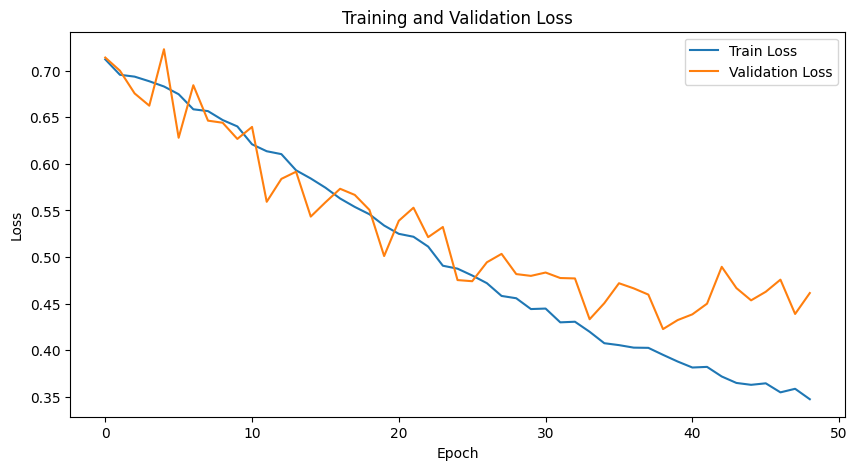


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.52      0.11       104
           1       0.98      0.74      0.85      3161

    accuracy                           0.74      3265
   macro avg       0.52      0.63      0.48      3265
weighted avg       0.95      0.74      0.82      3265



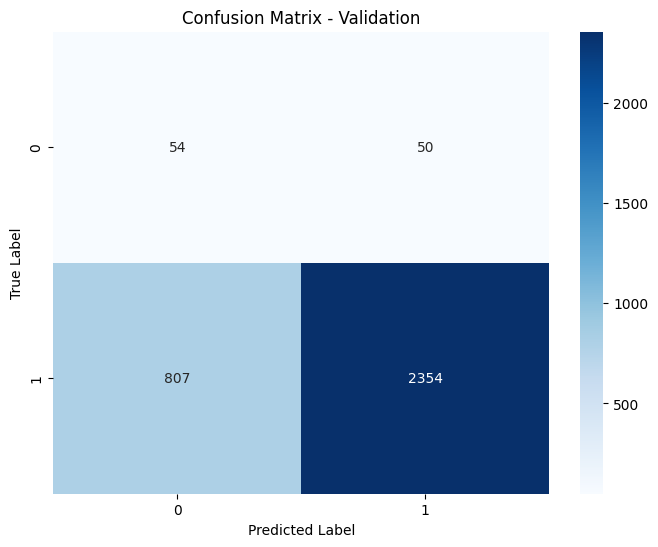


Test Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.37      0.11       243
           1       0.97      0.79      0.87      6262

    accuracy                           0.78      6505
   macro avg       0.52      0.58      0.49      6505
weighted avg       0.94      0.78      0.84      6505



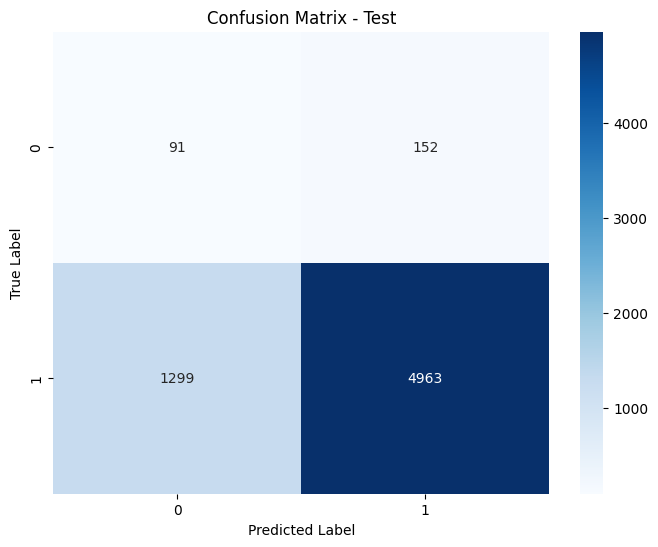

The function took 0.2185 seconds to execute.
The function took 0.0528 seconds to execute.
The function took 0.1019 seconds to execute.
Train Accuracy: 87.6570
Validation Accuracy: 73.7519
Test Accuracy: 77.6941


In [ ]:
# FFNN with sequential identifiers
class FFNN(nn.Module):
  def __init__(self, input_size):
        super(FFNN, self).__init__()
        self.hidden_layer1 = nn.Linear(in_features=input_size, out_features=64)
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=64)
        self.hidden_layer3 = nn.Linear(in_features=64, out_features=32)
        self.hidden_layer4 = nn.Linear(in_features=32, out_features=32)
        self.hidden_layer5 = nn.Linear(in_features=32, out_features=16)
        self.output_layer = nn.Linear(in_features=16,out_features=2)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

  def forward(self, x):
      x = self.relu(self.hidden_layer1(x))
      x = self.dropout(x)
      x = self.relu(self.hidden_layer2(x))
      x = self.dropout(x)
      x = self.relu(self.hidden_layer3(x))
      x = self.dropout(x)
      x = self.relu(self.hidden_layer4(x))
      x = self.dropout(x)
      x = self.relu(self.hidden_layer5(x))
      x = self.dropout(x)
      return self.output_layer(x)

neurons = 128

# Create tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

#Create Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Weights to oversample minority class (SMOTE was wrong in this case)
class_counts = torch.bincount(y_train_tensor)
sample_weights = 1.0 / class_counts[y_train_tensor]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")
model = FFNN(90)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Testing multiple optimizer and differents lr
optimizer = optim.Adamax(model.parameters(), lr=0.0005) # "best"
#optimizer = optim.ASDG(model.parameters(), lr=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=0.0005)
#optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.0003)
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta=0.001, patience=10)

#report on classification report per model
val_accuracy, val_report, _, _ = evaluate_model(model, val_loader, device, "Validation")
test_accuracy, test_report, _, _ = evaluate_model(model, test_loader, device, "Test")

#testing
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


## Learnable Embeddings

The device is set to: cuda
Epoch 20/100, Train Loss: 0.1752, Val Loss: 0.2087
Early stopping at epoch 38 (best val loss: 0.159371)
The function took 32.0453 seconds to execute.


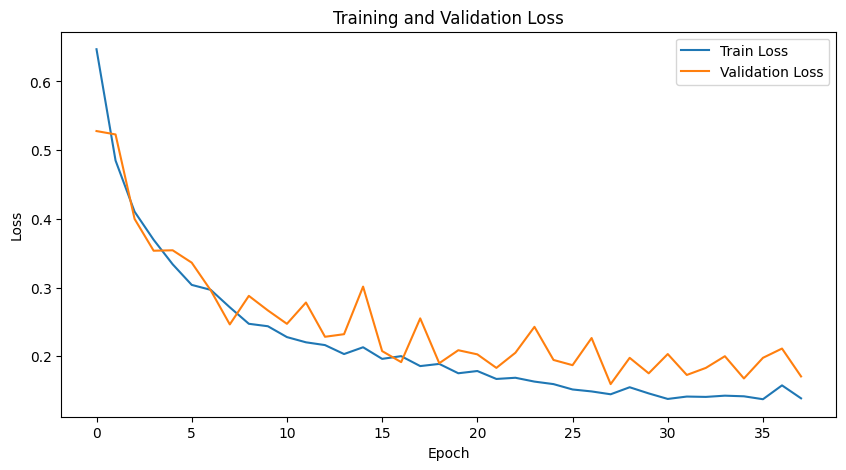


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.86      0.56       104
           1       1.00      0.96      0.98      3161

    accuracy                           0.96      3265
   macro avg       0.71      0.91      0.77      3265
weighted avg       0.98      0.96      0.96      3265



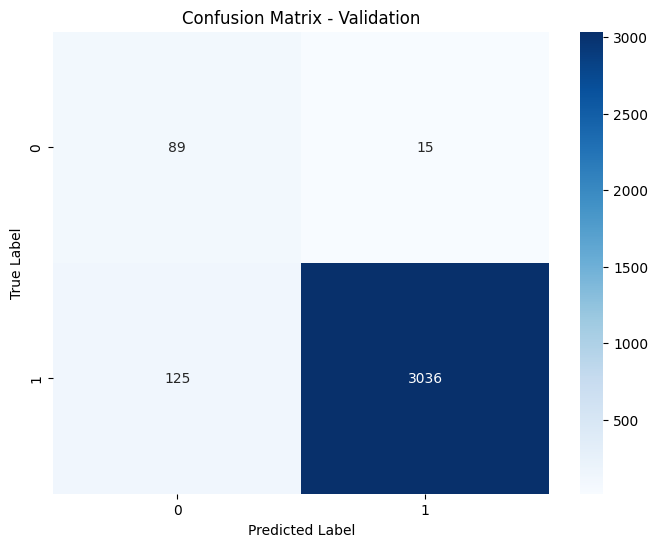


Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.76      0.55       243
           1       0.99      0.96      0.98      6262

    accuracy                           0.95      6505
   macro avg       0.71      0.86      0.76      6505
weighted avg       0.97      0.95      0.96      6505



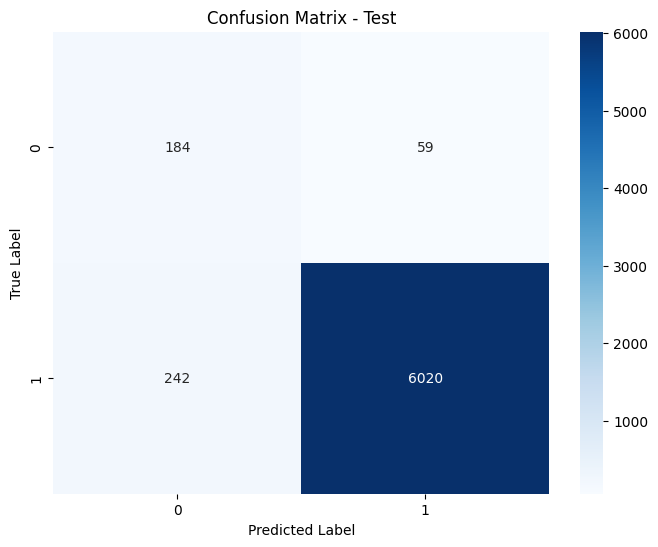

The function took 0.2552 seconds to execute.
The function took 0.0675 seconds to execute.
The function took 0.1266 seconds to execute.
Train Accuracy: 96.6692
Validation Accuracy: 95.7121
Test Accuracy: 95.3728


In [ ]:
# Classifier using learnable embeddings

class EmbeddedClassifier(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, pad_idx):
        super(EmbeddedClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_dim, embedding_dim, padding_idx=pad_idx)
        self.hidden_layer1 = nn.Linear(in_features=embedding_dim, out_features=64)
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=64)
        self.hidden_layer3 = nn.Linear(in_features=64, out_features=32)
        self.hidden_layer4 = nn.Linear(in_features=32, out_features=32)
        self.hidden_layer5 = nn.Linear(in_features=32, out_features=16)
        self.output_layer = nn.Linear(in_features=16, out_features=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, sequences):
        # sequences: (batch, seq_len)
        embedding = self.embedding(sequences)  # (batch, seq_len, embedding_dim)
        # mask to discard PADs
        mask = (sequences != 0).unsqueeze(-1).float()
        summed = (embedding * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        mean_emb = summed / lengths  # (batch, embedding_dim)
        x = self.relu(self.hidden_layer1(mean_emb))
        x = self.dropout(x)
        x = self.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = self.relu(self.hidden_layer3(x))
        x = self.dropout(x)
        x = self.relu(self.hidden_layer4(x))
        x = self.dropout(x)
        x = self.relu(self.hidden_layer5(x))
        x = self.dropout(x)
        return self.output_layer(x)



# Create tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

#Create Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Weights to oversample minority class (SMOTE was wrong in this case)
class_counts = torch.bincount(y_train_tensor)
sample_weights = 1.0 / class_counts[y_train_tensor]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")
embed_dim = 64
model = EmbeddedClassifier(len(api_vocab),embed_dim,0)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta=0.001, patience=10)

#report on classification report per model
val_accuracy, val_report, _, _ = evaluate_model(model, val_loader, device, "Validation")
test_accuracy, test_report, _, _ = evaluate_model(model, test_loader, device, "Test")

#testing
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Task 3: Recursive Neural Network (RNN)

## Data

In [ ]:
def sequences_to_indices_for_rnn(sequences, api_to_idx):
    """Convert sequences of API calls to sequences of indices without padding."""
    sequences_indices = []
    unk_index = api_to_idx['UNK'] # Get the index for 'UNK'
    for seq in sequences:
        # Convert API calls to indices, defaulting to unk_index for unknown APIs
        seq_indices = [api_to_idx.get(api, unk_index) for api in seq]
        sequences_indices.append(seq_indices)
    return sequences_indices

In [ ]:
train_size = int(0.8 * len(df))

df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

In [ ]:
# Extract labels and features
X_train, y_train = df_train['api_call_sequence'], df_train.iloc[:, -1].values.astype(int)
X_val, y_val = df_val['api_call_sequence'], df_val.iloc[:, -1].values.astype(int)
X_test, y_test = df_test['api_call_sequence'], df_test.iloc[:, -1].values.astype(int)

# convert X to integer sequences
X_train = sequences_to_indices_for_rnn(X_train, api_to_idx)
X_val = sequences_to_indices_for_rnn(X_val, api_to_idx)
X_test = sequences_to_indices_for_rnn(X_test, api_to_idx)

In [ ]:
class MalwareDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

In [ ]:
def collate_fn(batch):
    # batch: list of tuples (sequence, label)
    sequences, labels = zip(*batch)
    # Get lengths of each sequence in the batch
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    # Pad sequences to the longest in the batch
    padded_seqs = pad_sequence(
        [torch.LongTensor(seq) for seq in sequences],
        batch_first=True,
        padding_value=0  # Use 0 for padding
    )
    # Ensure labels are stacked into a single tensor
    labels_tensor = torch.stack(labels) if labels else torch.tensor([], dtype=torch.float)
    return padded_seqs, lengths, labels_tensor

In [ ]:
batch_size = 32

train_dataset = MalwareDataset(X_train, y_train)
val_dataset = MalwareDataset(X_val, y_val)
test_dataset = MalwareDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Training loop + test function

In [ ]:
def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.

    Returns:
        None: The function plots the training and validation loss over the epochs.
    """


    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, lengths, batch_y in train_loader:
            batch_X, lengths, batch_y = batch_X.to(device), lengths.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X,lengths)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            # Check if val_loader is not empty before iterating
            if len(val_loader) > 0:
                for batch_X, lengths, batch_y in val_loader:
                    batch_X, lengths, batch_y = batch_X.to(device), lengths.to(device), batch_y.to(device)  # Move batch to GPU
                    val_outputs = model(batch_X,lengths)  # Forward pass
                    loss = criterion(val_outputs, batch_y)  # Compute validation loss
                    val_loss += loss.item() * batch_X.size(0)
                val_losses.append(val_loss / len(val_dataset))
            else:
                val_loss = float('nan') # Assign NaN if validation set is empty
                val_losses.append(val_loss)

            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return

def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, lengths, labels in dataloader:
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs,lengths)
            # For binary classification, threshold the sigmoid output at 0.5
            predicted = (outputs > 0.5).long() # Get predictions by thresholding at 0.5
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Define class names for binary classification
    # Assuming 0 is benign and 1 is malware
    class_names = ['Benign', 'Malware']

    # Plot the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=[0,1]) # Specify labels to ensure order
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Classification Report:\n{classification_report(all_labels, all_predictions, target_names=class_names)}")


    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

## RNN

cuda
Epoch 20/20, Train Loss: 0.0757, Val Loss: 0.1120
The function took 86.6482 seconds to execute.


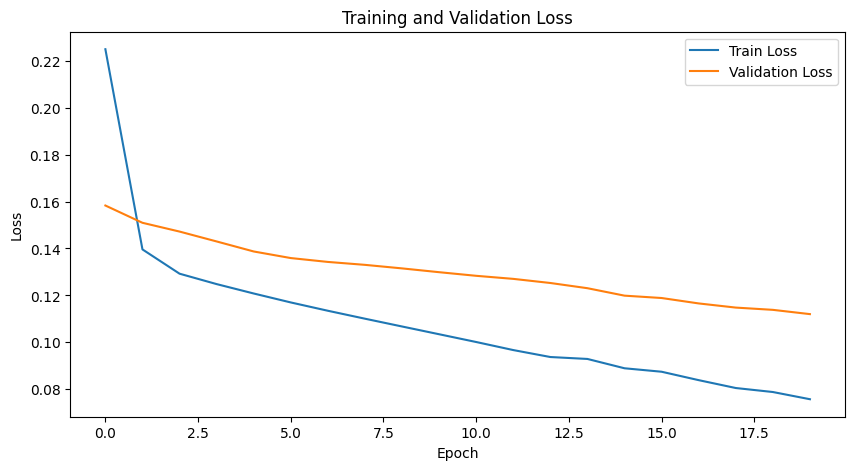

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True) # Use nn.RNN
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # x: (batch_size, seq_len), lengths: (batch_size,)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # Pack padded sequences
        packed = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed) # RNN returns (output, hidden)

        # hidden shape for RNN: (num_layers * num_directions, batch, hidden_size)
        # For a simple one-directional RNN, this is (1, batch_size, hidden_dim)
        last_hidden = hidden[-1]  # (batch_size, hidden_dim)

        # Pass through the fully connected layer
        out = self.fc(last_hidden)
        return self.sigmoid(out).squeeze(-1)

#Define the device to use for training and validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Define the Loss function, the optimizers, the architectures and train the models
criterion = nn.BCELoss()
# Define training parameters
num_epochs = 20
lr = 0.0001

RNNmodel = RNNClassifier(vocab_size=260, embed_dim=100, hidden_dim=64).to(device)
optimizer = optim.Adam(RNNmodel.parameters(), lr=lr)
training_loop(RNNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

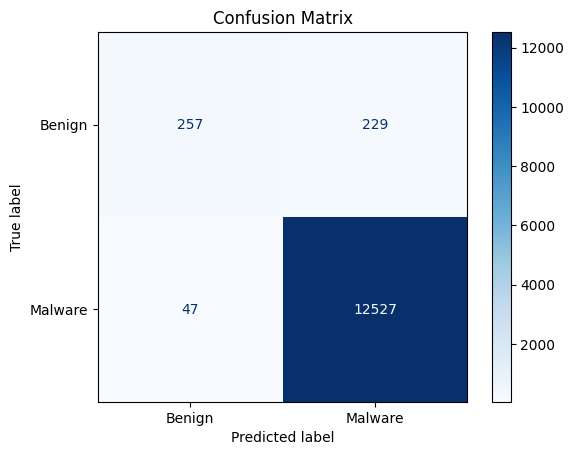

Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.53      0.65       486
     Malware       0.98      1.00      0.99     12574

    accuracy                           0.98     13060
   macro avg       0.91      0.76      0.82     13060
weighted avg       0.98      0.98      0.98     13060

The function took 1.7087 seconds to execute.
Train Accuracy: 97.8867


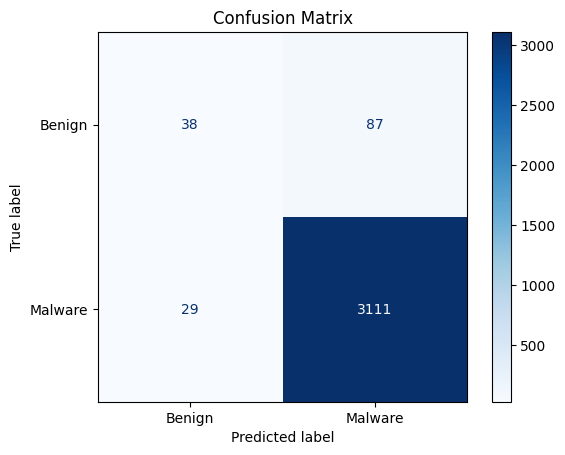

Classification Report:
              precision    recall  f1-score   support

      Benign       0.57      0.30      0.40       125
     Malware       0.97      0.99      0.98      3140

    accuracy                           0.96      3265
   macro avg       0.77      0.65      0.69      3265
weighted avg       0.96      0.96      0.96      3265

The function took 0.5153 seconds to execute.
Validation Accuracy: 96.4472


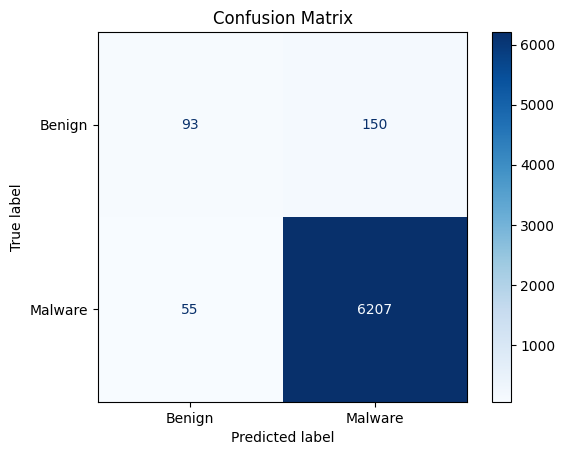

Classification Report:
              precision    recall  f1-score   support

      Benign       0.63      0.38      0.48       243
     Malware       0.98      0.99      0.98      6262

    accuracy                           0.97      6505
   macro avg       0.80      0.69      0.73      6505
weighted avg       0.96      0.97      0.96      6505

The function took 0.9398 seconds to execute.
Test Accuracy: 96.8486


In [ ]:
train_accuracy = testing_model(RNNmodel,train_loader,device)
print(f'Train Accuracy: {train_accuracy:.4f}')
val_accuracy = testing_model(RNNmodel,val_loader,device)
print(f'Validation Accuracy: {val_accuracy:.4f}')
test_accuracy = testing_model(RNNmodel,test_loader,device)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Bidir RNN

cuda
Epoch 20/20, Train Loss: 0.0569, Val Loss: 0.1283
The function took 127.2726 seconds to execute.


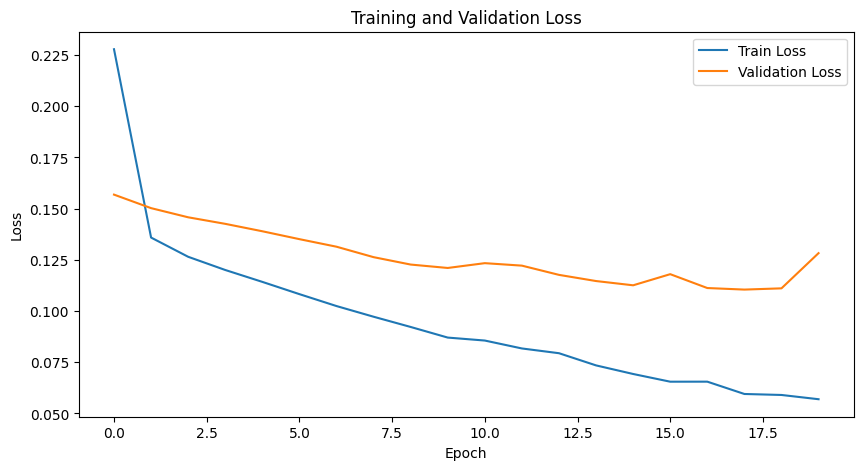

In [ ]:
class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(2 * hidden_dim, 1) # 2 for bidirectional

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)

        # hidden shape for BiRNN: (num_layers * num_directions, batch, hidden_size)
        # Concatenate the last layer's forward and backward hidden states
        last_forward_hidden = hidden[-2, :, :]
        last_backward_hidden = hidden[-1, :, :]
        combined_hidden = torch.cat((last_forward_hidden, last_backward_hidden), dim=1)

        out = self.fc(combined_hidden)
        return out.squeeze(-1) # Return logits, use BCEWithLogitsLoss

# Define the device to use for training and validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the Loss function, the optimizers, the architectures and train the models
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for numerical stability
# Define training parameters
num_epochs = 20
lr = 0.0001

BiRNNmodel = BiRNNClassifier(vocab_size=260, embed_dim=100, hidden_dim=64, num_layers=2).to(device)
optimizer = optim.Adam(BiRNNmodel.parameters(), lr=lr)
training_loop(BiRNNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)


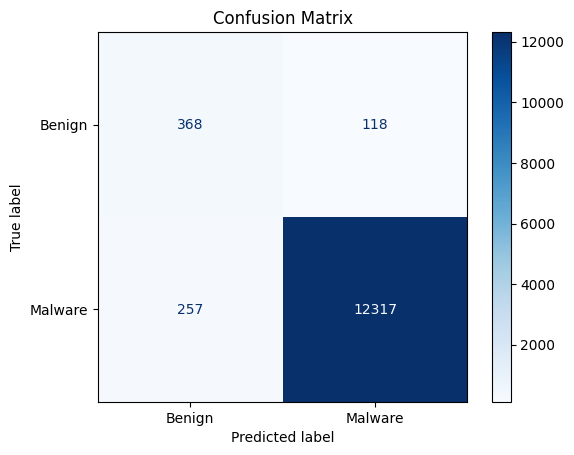

Classification Report:
              precision    recall  f1-score   support

      Benign       0.59      0.76      0.66       486
     Malware       0.99      0.98      0.99     12574

    accuracy                           0.97     13060
   macro avg       0.79      0.87      0.82     13060
weighted avg       0.98      0.97      0.97     13060

The function took 2.3952 seconds to execute.
Train Accuracy: 97.1286


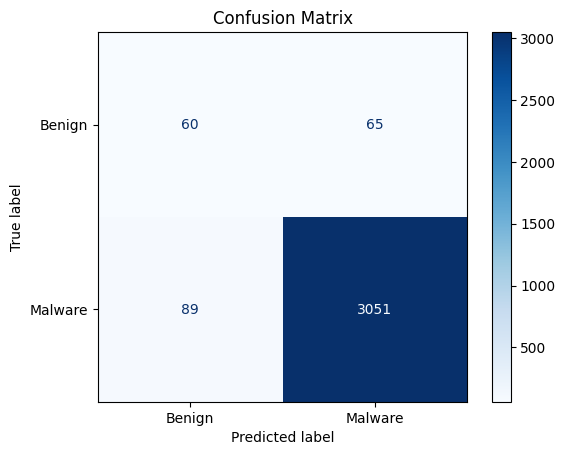

Classification Report:
              precision    recall  f1-score   support

      Benign       0.40      0.48      0.44       125
     Malware       0.98      0.97      0.98      3140

    accuracy                           0.95      3265
   macro avg       0.69      0.73      0.71      3265
weighted avg       0.96      0.95      0.95      3265

The function took 0.6936 seconds to execute.
Validation Accuracy: 95.2833


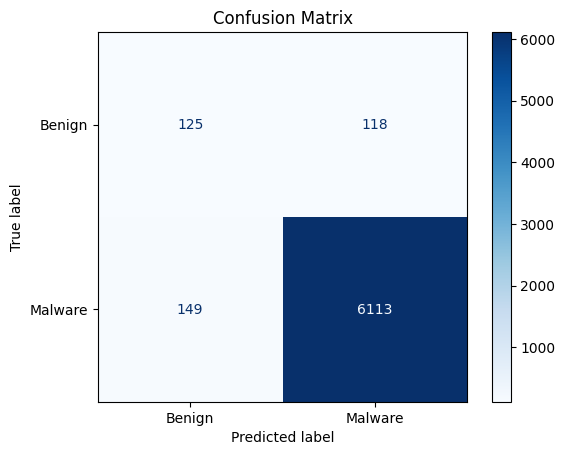

Classification Report:
              precision    recall  f1-score   support

      Benign       0.46      0.51      0.48       243
     Malware       0.98      0.98      0.98      6262

    accuracy                           0.96      6505
   macro avg       0.72      0.75      0.73      6505
weighted avg       0.96      0.96      0.96      6505

The function took 1.3415 seconds to execute.
Test Accuracy: 95.8955


In [ ]:
train_accuracy = testing_model(BiRNNmodel,train_loader,device)
print(f'Train Accuracy: {train_accuracy:.4f}')
val_accuracy = testing_model(BiRNNmodel,val_loader,device)
print(f'Validation Accuracy: {val_accuracy:.4f}')
test_accuracy = testing_model(BiRNNmodel,test_loader,device)
print(f'Test Accuracy: {test_accuracy:.4f}')

## LSTM

- embed dim = 100
- bidir = True
- dropout = 0.2
- num_layers = 2

cuda
The function took 75.7962 seconds to execute.


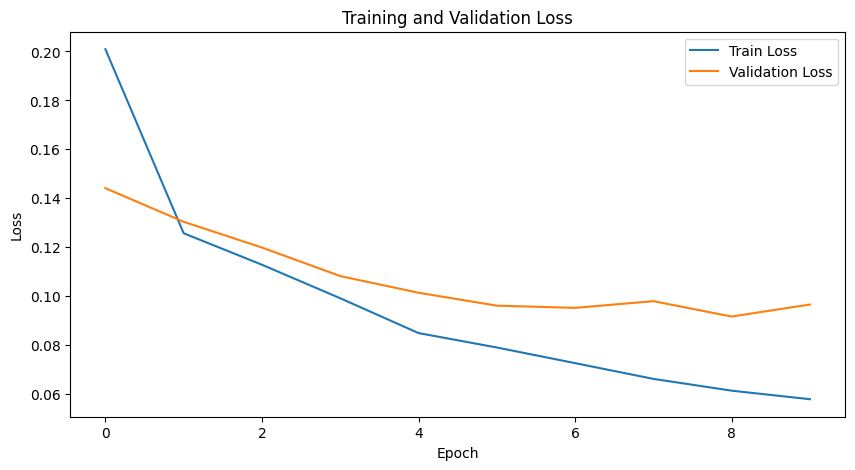

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Stacked LSTM with 2 layers (or num_layers specified)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,  # Number of LSTM layers
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,  # Add dropout between layers
            bidirectional=True
        )
        self.fc = nn.Linear(2*hidden_dim, 1) # 2 lstm !

    def forward(self, x, lengths):
        # x: (batch_size, seq_len), lengths: (batch_size,)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # Pack padded sequences
        packed = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, _) = self.lstm(packed)
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)

        # hidden shape: (num_layers * num_directions, batch, hidden_size)
        # Concatenate the last forward and last backward hidden states from the *last* layer
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        # Pass through the fully connected layer
        return self.fc(hidden).squeeze(-1)  # (batch_size,)

#Define the device to use for training and validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Define the Loss function, the optimizers, the architectures and train the models
criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss because the model outputs logits
# Define training parameters
num_epochs = 10
lr = 0.0001

LSTMmodel = LSTMClassifier(vocab_size=260, embed_dim=128, hidden_dim=128).to(device)
optimizer = optim.Adam(LSTMmodel.parameters(), lr=lr)
training_loop(LSTMmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

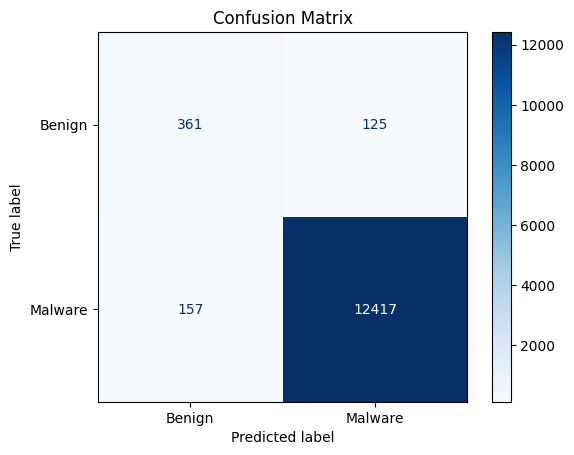

Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.74      0.72       486
     Malware       0.99      0.99      0.99     12574

    accuracy                           0.98     13060
   macro avg       0.84      0.87      0.85     13060
weighted avg       0.98      0.98      0.98     13060

The function took 2.9847 seconds to execute.
Train Accuracy: 97.8407


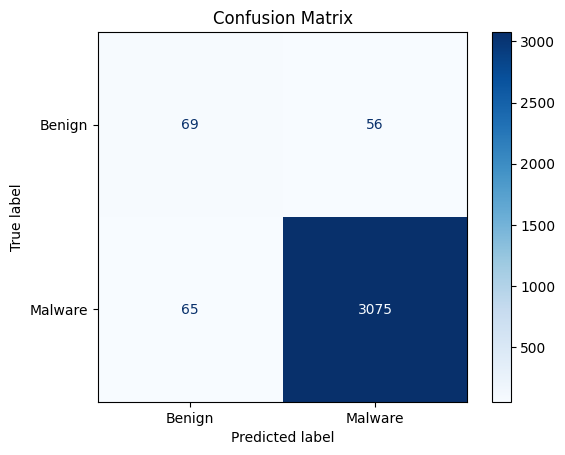

Classification Report:
              precision    recall  f1-score   support

      Benign       0.51      0.55      0.53       125
     Malware       0.98      0.98      0.98      3140

    accuracy                           0.96      3265
   macro avg       0.75      0.77      0.76      3265
weighted avg       0.96      0.96      0.96      3265

The function took 0.7343 seconds to execute.
Validation Accuracy: 96.2940


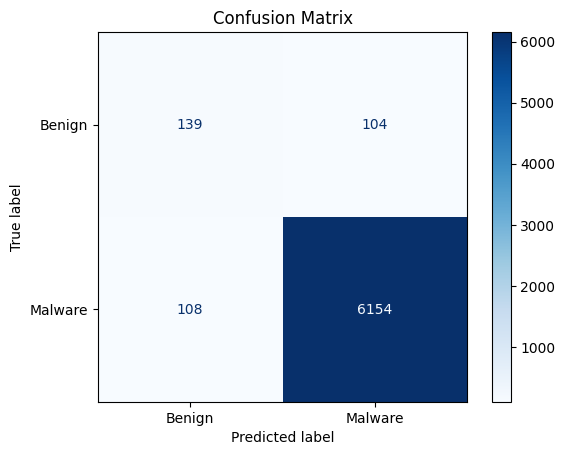

Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.57      0.57       243
     Malware       0.98      0.98      0.98      6262

    accuracy                           0.97      6505
   macro avg       0.77      0.78      0.78      6505
weighted avg       0.97      0.97      0.97      6505

The function took 1.7643 seconds to execute.
Test Accuracy: 96.7410


In [ ]:
train_accuracy = testing_model(LSTMmodel,train_loader,device)
print(f'Train Accuracy: {train_accuracy:.4f}')
val_accuracy = testing_model(LSTMmodel,val_loader,device)
print(f'Validation Accuracy: {val_accuracy:.4f}')
test_accuracy = testing_model(LSTMmodel,test_loader,device)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Task 4: Graph Neural Network (GNN)

In [ ]:
!pip install torch_geometric
import networkx as nx
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as GeometricDataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool, GraphNorm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:00


In [ ]:
# Define train-validation split index
train_size = int(0.8 * len(df))

# Use the last 20% of the time-series for validation
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

class GraphDataset(Dataset):
    def __init__(self, sequences, labels, api_to_idx, transform=None):
        """
        Initialize dataset using API sequences directly.

        Args:
            sequences (list): List of API sequences
            labels (list): List of graph labels (as integers, not one-hot)
            api_to_idx (dict): Mapping from API to index
            transform (callable, optional): Optional transform to apply to data.
        """
        super().__init__()
        self.graphs = []  # Store processed graphs
        self.api_to_idx = api_to_idx

        for i in range(len(sequences)):
            # Convert API sequence to graph representation
            graph_data = self.sequence_to_graph_data(sequences[i], labels[i])
            self.graphs.append(graph_data)

    def __getitem__(self, index):
        return self.graphs[index]

    #custom function to convert sequence to graph
    def sequence_to_graph_data(self, api_sequence, label):
        """Convert a single API sequence to graph data"""

        n = len(api_sequence)

        # Node features = API index
        x = torch.tensor(
            [[self.api_to_idx.get(api, 0)] for api in api_sequence],
            dtype=torch.long
        )   # Shape: [num_nodes, 1]

        # Sequential edges
        if n > 1:
            edges = []
            for i in range(n - 1):
                edges.append([i, i+1])   # forward
                edges.append([i+1, i])   # backward

            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            # Single-node graph
            edge_index = torch.zeros((2, 0), dtype=torch.long)

        # Graph label
        y = torch.tensor([label], dtype=torch.long)

        return Data(x=x, edge_index=edge_index, y=y)

    def __len__(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

#Simple GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embed_dim):
        super(GCN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.conv1 = GCNConv(embed_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1).long()
        x = self.embedding(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)  # Aggregate node features. From Node to Graph Features
        x = self.fc(x)
        return x
#GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embed_dim):
        super(GraphSAGE, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.conv1 = SAGEConv(embed_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1).long()
        x = self.embedding(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)# Aggregate node features. From Node to Graph Features
        x = self.dropout2(x)
        x = self.fc(x)
        return x
#GAT
class GAT(torch.nn.Module):

    def __init__(self, num_apis, embed_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.embedding = nn.Embedding(num_apis, embed_dim)
        self.conv1 = GATConv(embed_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.squeeze(1).long()
        x = self.embedding(x)
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

## Train and testing

cuda
Now training the GCN model ...
Epoch 10/50, Train Loss: 0.2385, Val Loss: 0.3944
Epoch 20/50, Train Loss: 0.1593, Val Loss: 0.2558
Epoch 30/50, Train Loss: 0.1298, Val Loss: 0.2843
Epoch 40/50, Train Loss: 0.1007, Val Loss: 0.2758
Epoch 50/50, Train Loss: 0.0904, Val Loss: 0.2721
Training took 95.2002 seconds.


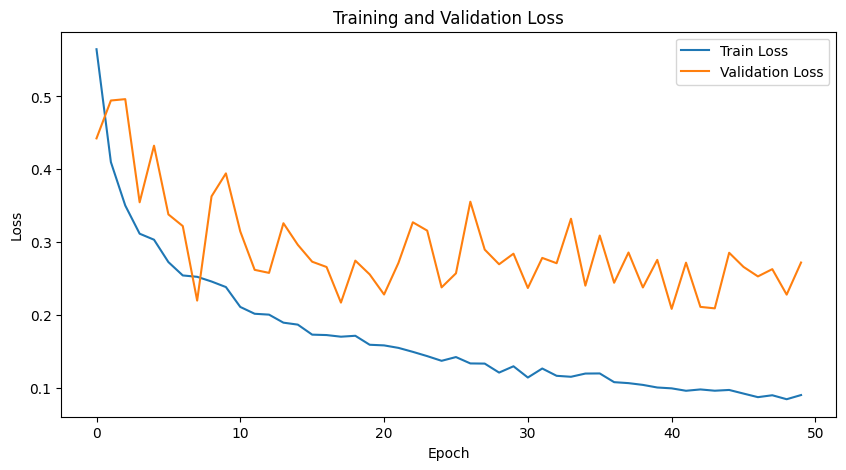

Now training the GraphSage model ...
Epoch 10/50, Train Loss: 0.2532, Val Loss: 0.3782
Epoch 20/50, Train Loss: 0.1811, Val Loss: 0.2351
Epoch 30/50, Train Loss: 0.1351, Val Loss: 0.2388
Epoch 40/50, Train Loss: 0.1236, Val Loss: 0.2078
Epoch 50/50, Train Loss: 0.1067, Val Loss: 0.1923
Training took 84.9488 seconds.


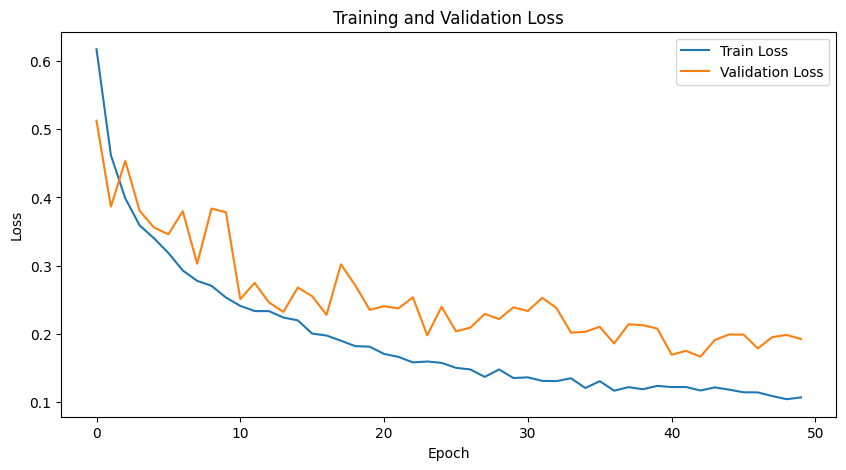

Now training the GAT model ...
Epoch 10/50, Train Loss: 0.2986, Val Loss: 0.3017
Epoch 20/50, Train Loss: 0.2139, Val Loss: 0.2590
Epoch 30/50, Train Loss: 0.1603, Val Loss: 0.2202
Epoch 40/50, Train Loss: 0.1452, Val Loss: 0.2007
Epoch 50/50, Train Loss: 0.1174, Val Loss: 0.1886
Training took 105.6027 seconds.


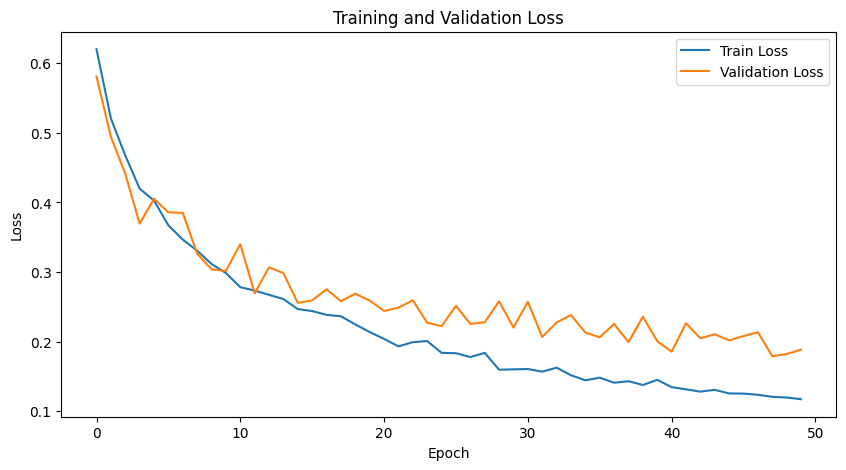

GCNmodel


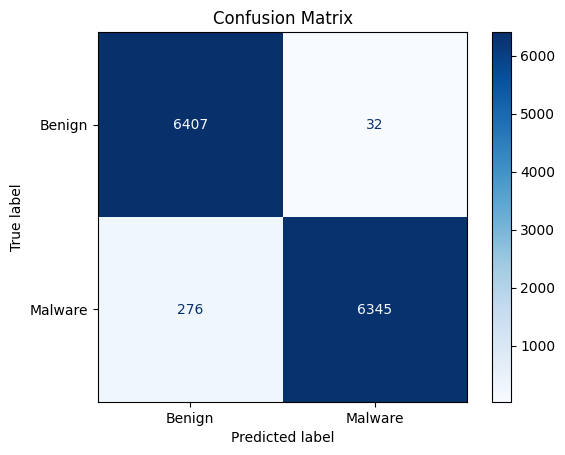

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98      6439
     Malware       0.99      0.96      0.98      6621

    accuracy                           0.98     13060
   macro avg       0.98      0.98      0.98     13060
weighted avg       0.98      0.98      0.98     13060

GCNmodel on Train - Accuracy: 97.64%
Testing took 1.1810 seconds.
Train Accuracy: 97.6417


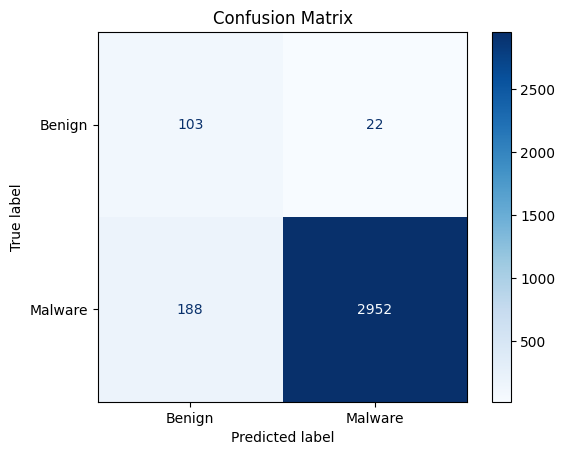

Classification Report:
              precision    recall  f1-score   support

      Benign       0.35      0.82      0.50       125
     Malware       0.99      0.94      0.97      3140

    accuracy                           0.94      3265
   macro avg       0.67      0.88      0.73      3265
weighted avg       0.97      0.94      0.95      3265

GCNmodel on Validation - Accuracy: 93.57%
Testing took 0.3809 seconds.
Validation Accuracy: 93.5681


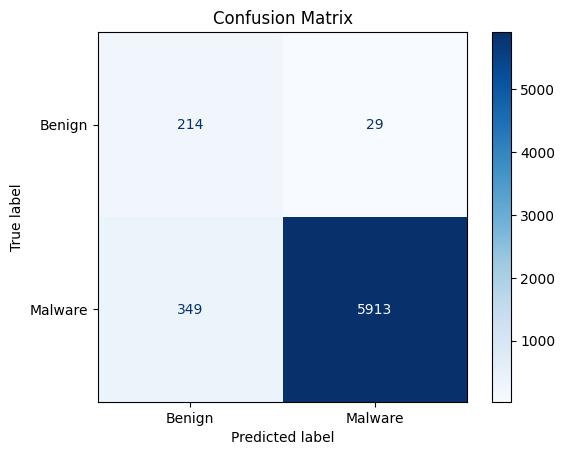

Classification Report:
              precision    recall  f1-score   support

      Benign       0.38      0.88      0.53       243
     Malware       1.00      0.94      0.97      6262

    accuracy                           0.94      6505
   macro avg       0.69      0.91      0.75      6505
weighted avg       0.97      0.94      0.95      6505

GCNmodel on Test - Accuracy: 94.19%
Testing took 0.6945 seconds.
Test Accuracy: 94.1891




GraphSAGEmodel


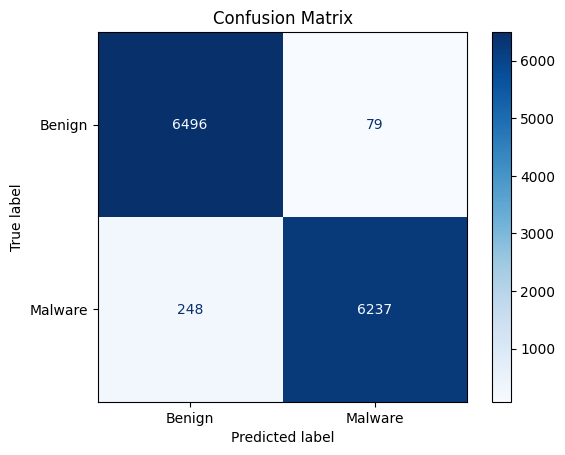

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.98      6575
     Malware       0.99      0.96      0.97      6485

    accuracy                           0.97     13060
   macro avg       0.98      0.97      0.97     13060
weighted avg       0.98      0.97      0.97     13060

GraphSAGEmodel on Train - Accuracy: 97.50%
Testing took 1.0002 seconds.
Train Accuracy: 97.4962


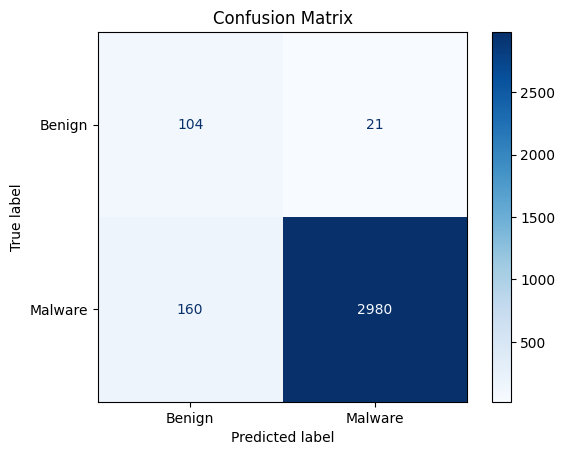

Classification Report:
              precision    recall  f1-score   support

      Benign       0.39      0.83      0.53       125
     Malware       0.99      0.95      0.97      3140

    accuracy                           0.94      3265
   macro avg       0.69      0.89      0.75      3265
weighted avg       0.97      0.94      0.95      3265

GraphSAGEmodel on Validation - Accuracy: 94.46%
Testing took 0.3546 seconds.
Validation Accuracy: 94.4564


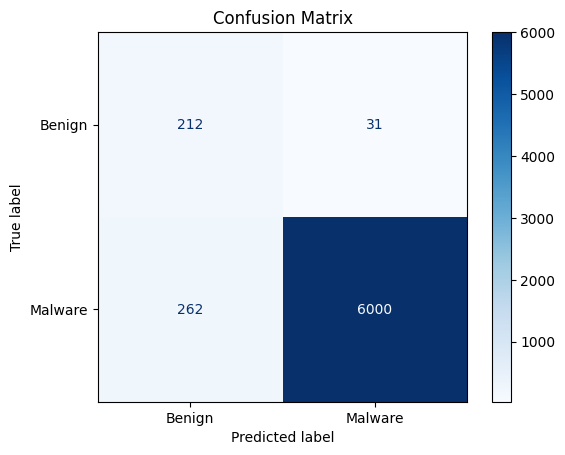

Classification Report:
              precision    recall  f1-score   support

      Benign       0.45      0.87      0.59       243
     Malware       0.99      0.96      0.98      6262

    accuracy                           0.95      6505
   macro avg       0.72      0.92      0.78      6505
weighted avg       0.97      0.95      0.96      6505

GraphSAGEmodel on Test - Accuracy: 95.50%
Testing took 0.5750 seconds.
Test Accuracy: 95.4958




GATmodel


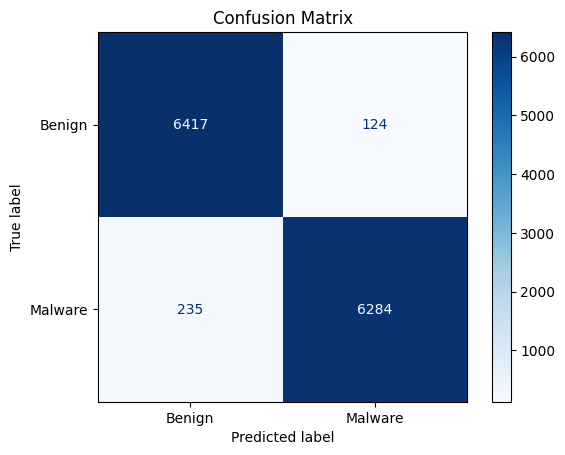

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97      6541
     Malware       0.98      0.96      0.97      6519

    accuracy                           0.97     13060
   macro avg       0.97      0.97      0.97     13060
weighted avg       0.97      0.97      0.97     13060

GATmodel on Train - Accuracy: 97.25%
Testing took 1.6715 seconds.
Train Accuracy: 97.2511


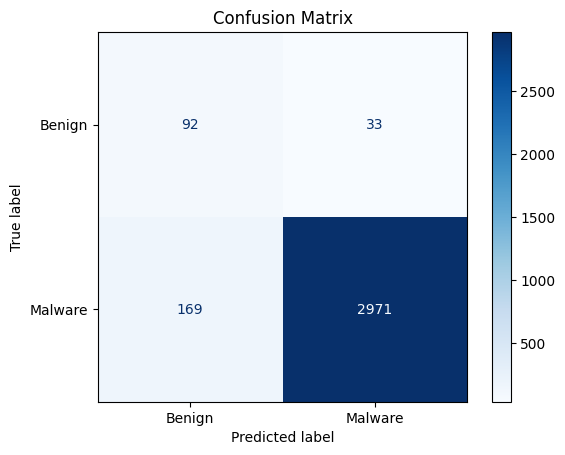

Classification Report:
              precision    recall  f1-score   support

      Benign       0.35      0.74      0.48       125
     Malware       0.99      0.95      0.97      3140

    accuracy                           0.94      3265
   macro avg       0.67      0.84      0.72      3265
weighted avg       0.96      0.94      0.95      3265

GATmodel on Validation - Accuracy: 93.81%
Testing took 0.4067 seconds.
Validation Accuracy: 93.8132


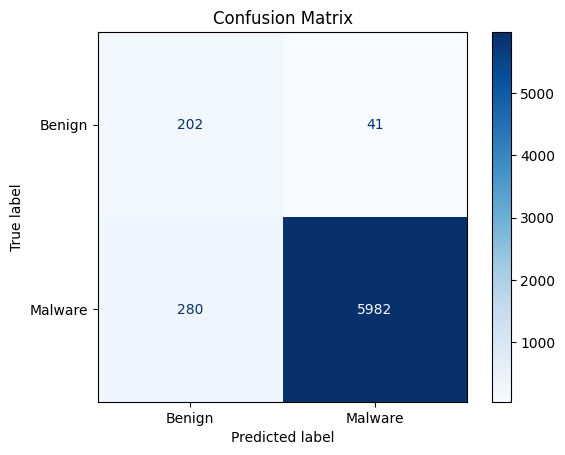

Classification Report:
              precision    recall  f1-score   support

      Benign       0.42      0.83      0.56       243
     Malware       0.99      0.96      0.97      6262

    accuracy                           0.95      6505
   macro avg       0.71      0.89      0.77      6505
weighted avg       0.97      0.95      0.96      6505

GATmodel on Test - Accuracy: 95.07%
Testing took 0.7156 seconds.
Test Accuracy: 95.0653






In [ ]:
def training_loop_GNN(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    """

    # Record the start time
    start_time = time.time()
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        model.train()

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            targets = batch.y
            if targets.dim() > 1 and targets.size(1) == 1:
              targets = targets.squeeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                val_outputs = model(batch)
                targets = batch.y
                if targets.dim() > 1 and targets.size(1) == 1:
                    targets = targets.squeeze(1)
                loss = criterion(val_outputs, targets)
                val_loss += loss.item() * batch.num_graphs

            val_loss /= len(val_dataset)
            val_losses.append(val_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Timing and plotting
    elapsed_time = time.time() - start_time
    print(f'Training took {elapsed_time:.4f} seconds.')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def testing_model_GNN(model, dataloader, device, dataset_name, model_name):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    """
    # Record the start time
    start_time = time.time()

    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)

            labels = batch.y
            if labels.dim() > 1 and labels.size(1) == 1:
                labels = labels.squeeze(1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    class_names = ['Benign', 'Malware']

    # Plot the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=[0,1]) # Specify labels to ensure order
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


    print(f"Classification Report:\n{classification_report(all_labels, all_predictions, target_names=class_names)}")

    print(f"{model_name} on {dataset_name} - Accuracy: {accuracy:.2f}%")

    elapsed_time = time.time() - start_time
    print(f'Testing took {elapsed_time:.4f} seconds.')

    return accuracy

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#Create the dataset
train_dataset_GNN = GraphDataset(df_train['api_call_sequence'].tolist(), y_train, api_to_idx)
val_dataset_GNN = GraphDataset(df_val['api_call_sequence'].tolist(), y_val, api_to_idx)
test_dataset_GNN = GraphDataset(df_test['api_call_sequence'].tolist(), y_test, api_to_idx)

# Weighted sampler
y_train_tensor = torch.tensor(y_train)
class_counts = torch.bincount(y_train_tensor)
sample_weights = 1.0 / class_counts[y_train_tensor]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader
train_loader_GNN = GeometricDataLoader(train_dataset_GNN, batch_size=64, sampler=sampler)
val_loader_GNN = GeometricDataLoader(val_dataset_GNN, batch_size=64, shuffle=False)
test_loader_GNN = GeometricDataLoader(test_dataset_GNN, batch_size=64, shuffle=False)

#create and test the models
criterion = nn.CrossEntropyLoss()
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print("Now training the GCN model ...")
GCNmodel = GCN(input_dim=len(api_to_idx)+1, hidden_dim=64, output_dim=2,embed_dim=64)
GCNmodel.to(device)
optimizer = optim.Adam(GCNmodel.parameters(), lr=0.0005, weight_decay=1e-4)
training_loop_GNN(GCNmodel, train_loader_GNN, val_loader_GNN, train_dataset_GNN, val_dataset_GNN, device, optimizer, num_epochs, criterion)

print("Now training the GraphSage model ...")
GraphSAGEmodel = GraphSAGE(input_dim=len(api_to_idx)+1, hidden_dim=32, output_dim=2, embed_dim=32)
GraphSAGEmodel.to(device)
optimizer = optim.Adam(GraphSAGEmodel.parameters(), lr=0.0005, weight_decay=1e-4)
training_loop_GNN(GraphSAGEmodel, train_loader_GNN, val_loader_GNN, train_dataset_GNN, val_dataset_GNN, device, optimizer, num_epochs, criterion)

print("Now training the GAT model ...")
GATmodel = GAT(num_apis=len(api_to_idx)+1, hidden_dim=32, output_dim=2, embed_dim=64)
GATmodel.to(device)
optimizer = optim.Adam(GATmodel.parameters(), lr=0.0001, weight_decay=1e-4)
training_loop_GNN(GATmodel, train_loader_GNN, val_loader_GNN, train_dataset_GNN, val_dataset_GNN, device, optimizer, num_epochs, criterion)

#Test the models
model_names = ["GCNmodel","GraphSAGEmodel","GATmodel"]
models = [GCNmodel,GraphSAGEmodel,GATmodel]
for i in range(len(model_names)):
    model = models[i]
    print(50*"=")
    print(model_names[i])
    print(50*"=")
    train_accuracy = testing_model_GNN(model,train_loader_GNN,device,"Train",model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model_GNN(model,val_loader_GNN,device,"Validation",model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model_GNN(model,test_loader_GNN,device,"Test",model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print("\n\n\n")

